This is part of the analysis part for the artist network. It involves finding 

To do (Julia):
- import network to work on in networkx (seems to be the most relevant library), using priority information to construct a weighted digraph
- run community detection algorithm(s) and tune hyperparameters (and write up in evaluation of metrics section)
- run central point detection algorithm/metrics (NOT degree centrality, but pagerank or something else could work)
- re-export node data with additional columns for node community and whether it is central

In [1]:
import pandas as pd #to read dataset files
import networkx as nx #for network analysis
import matplotlib.pyplot as plt #for some plots and evaluation of the analysis
import numpy as np
import random

# Community Detection in Networkx
 - Girvan-Newman - related to betweenness centrality (by default removes edge with highest betweenness centrality each iteration, but can be customized); can make weighted
    - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman
 - Fluid Communities - takes number communities k as hyperparameter, has random initialization; does not support weighted graphs (so not for us)
 - Clique Percolation - only finds cliques; probably not for us
 - Kernighan-Lin - partitions graph into 2; might want a more variable number of communities; not for us
 - Label propagation - essentially does label assignment until each node has the label of the majority of its neighbors in a weighted way
    - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.asyn_lpa_communities.html#networkx.algorithms.community.label_propagation.asyn_lpa_communities
 - Louvain algorithm - uses modularity; takes weight into account
    - "The most popular community detection algorithm in the space"
    - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities
 - Greedy modularity-based algorithm, if Louvain takes too long
    - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities



(source: https://memgraph.com/blog/community-detection-algorithms-with-python-networkx)

I can check how well the algorithms perform with modularity (including weights), which we want to maximize. Modularity is in [-1, 1] and a higher modularity signifies a better clustering. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity

In [2]:
# #first getting algs showing with dummy dataset
# G = nx.karate_club_graph().to_directed()
# #add weights to edges
# random.seed(0)
# for e in G.edges():
#     G[e[0]][e[1]]['weight'] = random.uniform(0, 1)

In [3]:
# nx.draw_networkx(G)

In [4]:
# print(G.edges())
# example_edge = (0, 1)
# print(G.get_edge_data(example_edge[0], example_edge[1]))

In [5]:
#importing data, using edges file
edges = pd.read_csv('./content/edges.csv')

In [6]:
edges.head()

,Unnamed: 0,source_artist_id,target_artist_id,priority
0,0,AR003FB1187B994355,ARYACSL1187FB51611,1
1,1,AR003FB1187B994355,ARYLCCQ1187B999F4B,2
2,2,AR003FB1187B994355,AR783EH1187B9921DD,3
3,3,AR003FB1187B994355,AR146Z8119B866996C,4
4,4,AR003FB1187B994355,AR5WAUE1187FB40839,5


In [7]:
edges['weight'] = (100 - edges['priority'])/100
#weight is in [0,1] and higher weights correspond to earlier artists in the list of similar artists

In [8]:
edges.head()

,Unnamed: 0,source_artist_id,target_artist_id,priority,weight
0,0,AR003FB1187B994355,ARYACSL1187FB51611,1,0.99
1,1,AR003FB1187B994355,ARYLCCQ1187B999F4B,2,0.98
2,2,AR003FB1187B994355,AR783EH1187B9921DD,3,0.97
3,3,AR003FB1187B994355,AR146Z8119B866996C,4,0.96
4,4,AR003FB1187B994355,AR5WAUE1187FB40839,5,0.95


In [9]:
print(len(edges))

2002865


In [10]:
# #Collapse all edges of the same type between the same two nodes by summing their weights
# edges1 = edges.groupby(['source_artist_id', 'target_artist_id'])['weight'].sum().reset_index()
# print(len(edges1))# was same, did nothing

In [11]:
#convert dataframe to networkx graph
G = nx.from_pandas_edgelist(edges, source='source_artist_id', target='target_artist_id',edge_attr=True, create_using=nx.DiGraph())

In [12]:
# print(G.edges())
example_edge = ('AR003FB1187B994355', 'ARYACSL1187FB51611')
print(G.get_edge_data(example_edge[0], example_edge[1]))

{'Unnamed: 0': 0, 'priority': 1, 'weight': 0.99}


In [13]:
# nx.draw_networkx(G)

# Girvan-Newman
Actually decided to omit this one, since it copies to an undirected graph in the source code (it doesn't use the directedness) and it is very computationally expensive.

source: https://stackoverflow.com/questions/62951320/why-is-the-girvan-newman-algorithm-in-networkx-so-slow

In [14]:
#make sure it uses weights when calculating betweeness centrality by providing custom function, based on API example
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight="weight")
    return max(centrality, key=centrality.get)

In [15]:
# #Girvan-Newman: based on edge betweeness
# girvan_newman_communities_possibilities = nx.algorithms.community.girvan_newman(G, most_valuable_edge=most_central_edge)
# #gives iterator of possible partitions, turn into list, many online examples only use first term
# girvan_newman_communities = tuple(sorted(c) for c in next(girvan_newman_communities_possibilities))

In [16]:
def display_graph_of_communities(G, communities):
  print(len(communities), " communities")
  colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
  pos = nx.spring_layout(G)
  color_map = {}
  keys = G.nodes()
  values = "black"
  for i in keys:
    color_map[i] = values
  for c in range(len(communities)):
    #in community c
    for node in communities[c]:
      color_map[node] = colors[c]
  nx.draw_networkx_edges(G, pos)
  nx.draw_networkx_nodes(G, pos, node_color=dict(color_map).values())
  nx.draw_networkx_labels(G, pos)
  plt.axis("off")
  plt.show()


In [17]:
# print("Girvan Newman alg")
# girvan_newman_modularity = nx.algorithms.community.modularity(G, girvan_newman_communities, weight='weight')
# print("Modularity: ", girvan_newman_modularity)
# display_graph_of_communities(G, girvan_newman_communities)

# Label propagation

In [18]:
#Label propagation
label_prop_communities_possibilities = nx.algorithms.community.asyn_lpa_communities(G, weight='weight', seed=0)#todo: add weight param
# print(label_prop_communities_possibilities)
# async version gives iterator of communities, turn into list
label_prop_communities = [tuple(c) for c in label_prop_communities_possibilities]
# print(label_prop_communities)
#runtime: 1 min 25 s

In [19]:
print("Label propagation alg")
label_prop_modularity = nx.algorithms.community.modularity(G, label_prop_communities, weight='weight')
print("Modularity: ", label_prop_modularity)
# display_graph_of_communities(G, label_prop_communities)

Label propagation alg
Modularity:  0.6769535889010251


# Louvain

In [20]:
# Louvain partition
louvain_communities_set = nx.algorithms.community.louvain_communities(G, weight='weight', seed=0)#this algorithm uses Louvain
louvain_communities = [tuple(c) for c in louvain_communities_set]
#runtime: 1 min 18s

In [21]:
print("Louvain alg")
louvain_modularity = nx.algorithms.community.modularity(G, louvain_communities, weight='weight')
print("Modularity: ", louvain_modularity)
# display_graph_of_communities(G, louvain_communities)

Louvain alg
Modularity:  0.6633771500232729


# Greedy modular communities

In [22]:
#greedy modular communities
greedy_communities_set = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')
greedy_communities = [tuple(c) for c in greedy_communities_set]
#time: 74 min (fast-ish on my M1 Mac, in Google Collab free it was still running at 2 1/2 hours)

In [23]:
print("Greedy modularity alg")
greedy_modularity = nx.algorithms.community.modularity(G, greedy_communities, weight='weight')
print("Modularity: ", greedy_modularity)
# display_graph_of_communities(G, greedy_communities)

Greedy modularity alg
Modularity:  0.5718171819400073


# Comparison of Algorithm Performance

In [24]:
algs = ["Label Propagation", "Louvain", "Greedy Modularity"]
modularities = [label_prop_modularity, louvain_modularity, greedy_modularity]
num_communities = [len(label_prop_communities), len(louvain_communities), len(greedy_communities)]

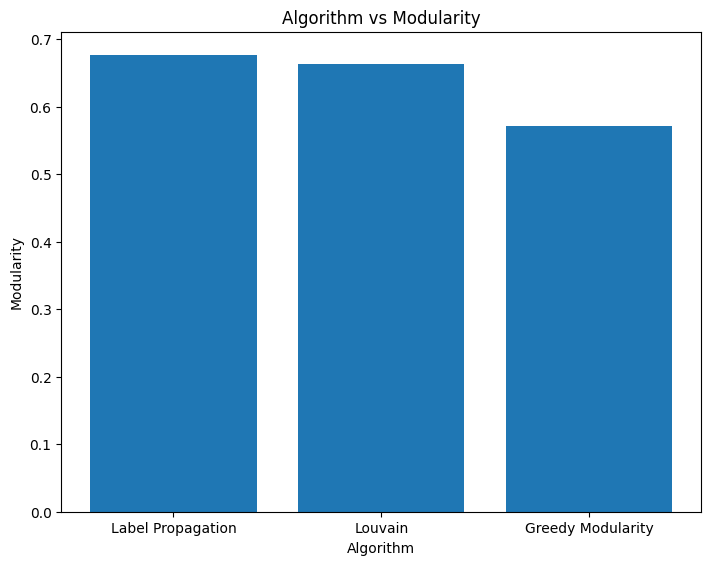

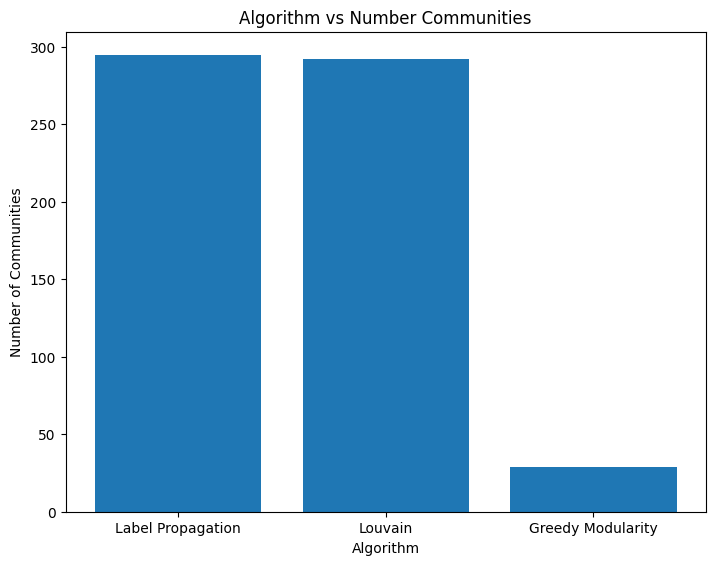

[295, 292, 29]


In [25]:
#make bar plots

# alg vs modularity
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(algs, modularities)
ax.set_title("Algorithm vs Modularity")
ax.set_xlabel("Algorithm")
ax.set_ylabel("Modularity")
plt.show()

# alg vs number of clusters
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.bar(algs, num_communities)
ax1.set_title("Algorithm vs Number Communities")
ax1.set_xlabel("Algorithm")
ax1.set_ylabel("Number of Communities")
plt.show()

print(num_communities)

In [26]:
best_alg_index = np.argmax(modularities)
print("Best algorithm was ", algs[best_alg_index], " with modularity ", modularities[best_alg_index])

Best algorithm was  Label Propagation  with modularity  0.6769535889010251


# Finding most central nodes: computing PageRank

In [27]:
#pagerank
rankings = nx.pagerank(G, weight='weight')#default alpha is 0.85

In [28]:
def return_el_1(item):#for use in sorting
  return item[1]

In [29]:
#get order of centrality (1 to len(nodes)) based on sorting rankings
rankings_list = list(rankings.items())
# has all nodes in (node, ranking) form
# sort based on rankings, descending
rankings_list.sort(reverse=True, key=return_el_1)

In [30]:
centrality_rank_dict = {rankings_list[i][0]: i+1 for i in range(len(rankings_list))}

# Updating nodes file with findings

In [31]:
#importing data, using nodes file
nodes = pd.read_csv('./content/nodes.csv')

In [32]:
nodes.head()

,Unnamed: 0,artist_id,avg_duration,total_tracks,avg_familiarity,avg_hotttnesss,artist_name,rank
0,0,ARTW7I31187B9A4CA9,290.024037,10,0.732966,0.482131,!!!,1
1,1,ARV82I61187B99E711,271.437915,2,0.473185,0.079863,!Bazz Feat. Siamak,1
2,2,ARN9GSE1187FB57A23,335.061751,15,0.521701,0.389536,!Deladap,1
3,3,ARI31A31187B9A7B6C,318.562810,2,0.391269,0.525509,#Poundsign#,1
4,4,ARPGMJP1241B9C99AE,281.745084,7,0.499202,0.000000,$jammie the Money,1


In [33]:
# add column for the centrality_rank
nodes["centrality_rank"] = nodes["artist_id"].map(centrality_rank_dict)

In [34]:
nodes.head()

,Unnamed: 0,artist_id,avg_duration,total_tracks,avg_familiarity,avg_hotttnesss,artist_name,rank,centrality_rank
0,0,ARTW7I31187B9A4CA9,290.024037,10,0.732966,0.482131,!!!,1,26393.0
1,1,ARV82I61187B99E711,271.437915,2,0.473185,0.079863,!Bazz Feat. Siamak,1,35443.0
2,2,ARN9GSE1187FB57A23,335.061751,15,0.521701,0.389536,!Deladap,1,13143.0
3,3,ARI31A31187B9A7B6C,318.562810,2,0.391269,0.525509,#Poundsign#,1,15381.0
4,4,ARPGMJP1241B9C99AE,281.745084,7,0.499202,0.000000,$jammie the Money,1,29664.0


In [35]:
# add in which community they are in for the optimal community
best_communities = label_prop_communities

In [36]:
community_dict = {}
for community_idx in range(len(best_communities)):
  community = best_communities[community_idx]
  for node in community:
    community_dict[node] = community_idx

In [37]:
# add column for the community
nodes["community"] = nodes["artist_id"].map(community_dict)

In [38]:
nodes.head()

,Unnamed: 0,artist_id,avg_duration,total_tracks,avg_familiarity,avg_hotttnesss,artist_name,rank,centrality_rank,community
0,0,ARTW7I31187B9A4CA9,290.024037,10,0.732966,0.482131,!!!,1,26393.0,1.0
1,1,ARV82I61187B99E711,271.437915,2,0.473185,0.079863,!Bazz Feat. Siamak,1,35443.0,25.0
2,2,ARN9GSE1187FB57A23,335.061751,15,0.521701,0.389536,!Deladap,1,13143.0,123.0
3,3,ARI31A31187B9A7B6C,318.562810,2,0.391269,0.525509,#Poundsign#,1,15381.0,1.0
4,4,ARPGMJP1241B9C99AE,281.745084,7,0.499202,0.000000,$jammie the Money,1,29664.0,23.0


In [39]:
#sanity check that artists with highest centrality rank are more well known
nodes.sort_values(by='centrality_rank').head(20)
#seems like, they are old but classic, so it makes some sense

,Unnamed: 0,artist_id,avg_duration,total_tracks,avg_familiarity,avg_hotttnesss,artist_name,rank,centrality_rank,community
6696,6696,ARFCUN31187B9AD578,230.693800,174,0.827890,0.744524,Chris Farlow,1,1.0,13.0
21273,21273,ARDIBRT1187B9AF176,400.008712,114,0.788992,0.638099,Led Zeppelin,1,2.0,4.0
27682,27682,ARNMM8611C8A415922,404.517724,18,0.533393,0.427150,Orjan Nilsen,1,3.0,41.0
24979,24979,ARVZU9D1187B9A899D,442.028390,24,0.510775,0.434798,Mike Foyle,1,4.0,41.0
36548,36548,AR6XZ861187FB4CECD,218.280502,59,0.840410,0.840463,The Beatles,1,5.0,1.0
26720,26720,ARBFQ7L1187B9ACD48,293.525558,129,0.744727,0.496130,Nico,1,6.0,1.0
33480,33480,ARJYIBO1187B9A312F,423.974456,38,0.576572,0.420185,Sinetone,1,7.0,41.0
26642,26642,ARJW50Q1187B98E5A4,484.575725,11,0.629300,0.417777,Nic Chagall,1,8.0,41.0
32653,32653,ARDLEWR119B866906A,436.764650,17,0.502518,0.382009,Sebastian Brandt,1,9.0,41.0
20443,20443,ARKO4ZW1187B98EA29,230.511003,15,0.675699,0.398687,Kool G Rap,1,10.0,8.0


In [40]:
#export to csv
nodes.to_csv("nodes_with_clusters.csv")

In [45]:
#sanity check that artists with highest centrality rank are more well known
sorted_nodes = nodes.sort_values(by='centrality_rank')
# sorted_nodes.head(20)
sorted_nodes[['artist_name', 'avg_familiarity', 'centrality_rank']].head(20)
#seems like, they are old but classic, so it makes some sense

,artist_name,avg_familiarity,centrality_rank
6696,Chris Farlow,0.827890,1.0
21273,Led Zeppelin,0.788992,2.0
27682,Orjan Nilsen,0.533393,3.0
24979,Mike Foyle,0.510775,4.0
36548,The Beatles,0.840410,5.0
26720,Nico,0.744727,6.0
33480,Sinetone,0.576572,7.0
26642,Nic Chagall,0.629300,8.0
32653,Sebastian Brandt,0.502518,9.0
20443,Kool G Rap,0.675699,10.0
